In [1]:
## !pip install pydrive
## !pip install textgrid
## !pip install librosa

In [2]:
import os
import glob
import json
import crepe
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pydub import AudioSegment
from textgrid import TextGrid, IntervalTier, Interval

In [3]:
output_directory = "data_out/"
audio_directory = "audio/"
text_grid_directory = "textgrid/"
json_directory = "json/"


if not os.path.exists(output_directory):
    os.makedirs(output_directory)
if not os.path.exists(output_directory + audio_directory):
    os.makedirs(output_directory + audio_directory)
if not os.path.exists(output_directory + text_grid_directory):
    os.makedirs(output_directory + text_grid_directory)
if not os.path.exists(output_directory + json_directory):
    os.makedirs(output_directory + json_directory)

In [4]:
def get_pitches_cr(file, confidence_floor=0):
    sr, audio = wavfile.read(file)
    time, frequency, confidence, _ = crepe.predict(audio, sr, viterbi=True)
    new_freq = []
    new_time = []
    for t, f, c in zip(time, frequency, confidence):
        if c > confidence_floor:
            new_freq.append(f)
            new_time.append(t)
    return new_freq, new_time

In [5]:
def get_intervals(file):
    grid = TextGrid.fromFile(file)
    word_tier = grid[0]
    labels = []
    durations = []
    for interval in word_tier:
            duration = interval.maxTime - interval.minTime
            durations.append(duration)
            labels.append(interval.mark)
    return labels, durations

In [6]:
def graph_audios(data):
    for i in range(len(data)):
        pitches = data[i]['pitches']
        pitch_int = data[i]['pitch_int']

        labels = data[i]['labels']
        label_int = data[i]['label_int']

        max_pitch_int = max(pitch_int)

        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.scatter(pitch_int, pitches, color='blue', alpha=0.5)
        ax1.set_title('Pitch vs. Pitch Interval with Segmented Labels')
        ax1.set_xlabel('Seconds')
        ax1.set_ylabel('Pitch (Hz)')
        ax1.set_ylim(0, max(pitches) + 20)
        ax1.set_xlim(0, max_pitch_int) 
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

        colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

        ax2 = fig.add_axes([0.125, 0.1, 0.775, 0.2])


        ax2.get_yaxis().set_visible(False)
        ax2.set_xlim(ax1.get_xlim())

        start_points = [0] + list(np.cumsum(label_int)[:-1])

        for i, (label, start, interval) in enumerate(zip(labels, start_points, label_int)):
            rect = mpatches.Rectangle((start, 0), interval, 1, color=colors[i])
            ax2.add_patch(rect)
            ax2.text(start + interval / 2, 0.5, label, ha='center', va='center')

        plt.show()

In [7]:
def extract_segments(wav_path, tg_path, pause_threshold=1000, buffer_time=500):
    audio = AudioSegment.from_wav(wav_path)

    tg = TextGrid.fromFile(tg_path)

    base_path = wav_path.split('.')[0]

    base_path = base_path.replace('data_segmented/', '')

    tier = tg[1]

    last_end = 0
    segment_index = 0
    total_duration = len(audio)
    all_audio = []
    for interval in tier:
        if interval.mark == "#" and interval.duration() > (pause_threshold/1000):

            start_time = max(0, int((last_end * 1000) - buffer_time))
            end_time = min(total_duration, int((interval.minTime * 1000) + buffer_time))


            segment = audio[start_time:end_time]

            segment_name = f"{base_path}_{segment_index}.wav"
            segment.export(os.path.join(str(output_directory + audio_directory), segment_name), format="wav")

            pitches = get_pitches_cr(os.path.join(str(output_directory + audio_directory), segment_name), 0.50)

            temp_dict = {
                "filename": f"{base_path}_{segment_index}",
                "pitches": pitches[0],
                "pitch_int": pitches[1],
                "audio_url": f"/file_processing/{output_directory + audio_directory}{segment_name}",
                "textgrid_url": f"/file_processing/{output_directory + text_grid_directory}{base_path}_{segment_index}.TextGrid",
            }

            tg_segment = TextGrid()
            new_tier = IntervalTier(name=tier.name, minTime=0, maxTime=(end_time-start_time)/1000.0)
            for intv in tier.intervals:
                intv_start = intv.minTime * 1000
                intv_end = intv.maxTime * 1000
                if intv_end > start_time and intv_start < end_time:
                    adjusted_start = max(intv_start - start_time, 0) / 1000.0
                    adjusted_end = min(intv_end - start_time, end_time - start_time) / 1000.0
                    new_interval = Interval(adjusted_start, adjusted_end, intv.mark)
                    new_tier.addInterval(new_interval)
            tg_segment.append(new_tier)
            tg_segment_name = f"{base_path}_{segment_index}.TextGrid"
            tg_segment.write(os.path.join(str(output_directory + text_grid_directory), tg_segment_name))

            intervals = get_intervals(os.path.join(str(output_directory + text_grid_directory), tg_segment_name))
            temp_dict['labels'] = intervals[0]
            temp_dict['label_int'] = intervals[1]

            # Save json
            json_file_path = os.path.join(str(output_directory + json_directory), f"{base_path}_{segment_index}.json")
            with open(json_file_path, 'w') as json_file:
                json.dump(temp_dict, json_file)

            all_audio.append(temp_dict)

            segment_index += 1
            last_end = interval.maxTime

    graph_audios(all_audio)

2024-05-15 10:10:21.480445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step
7/7 ━━━━━━━━━━━━━━━━━

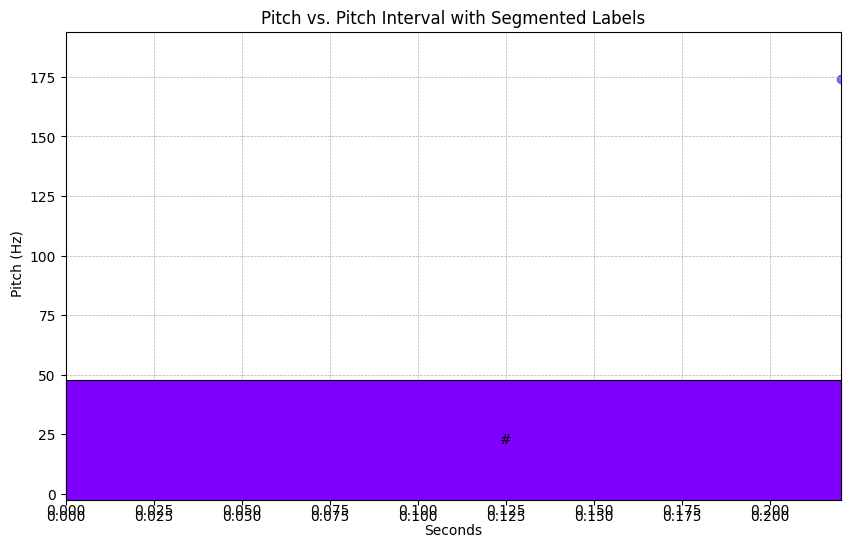

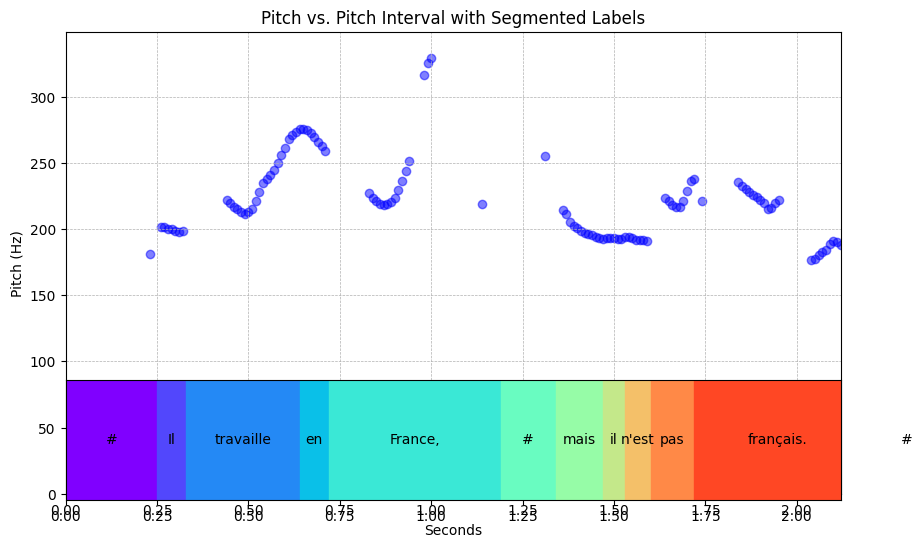

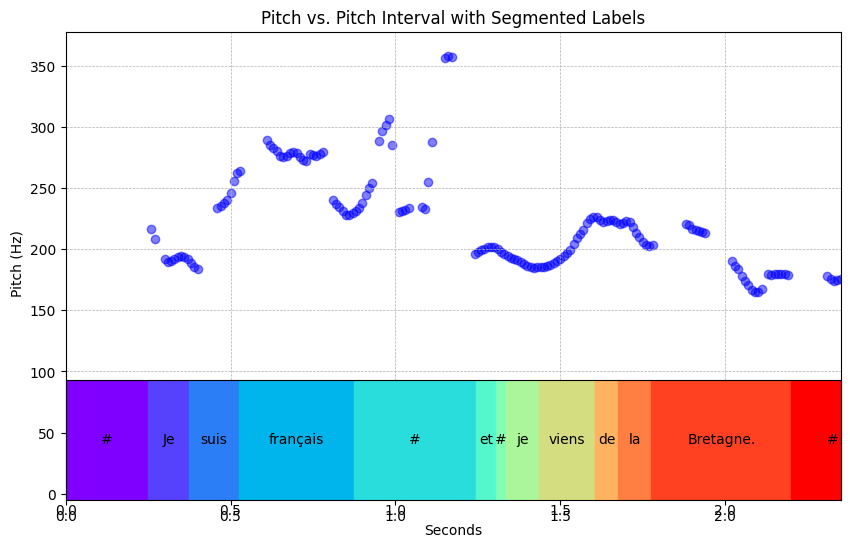

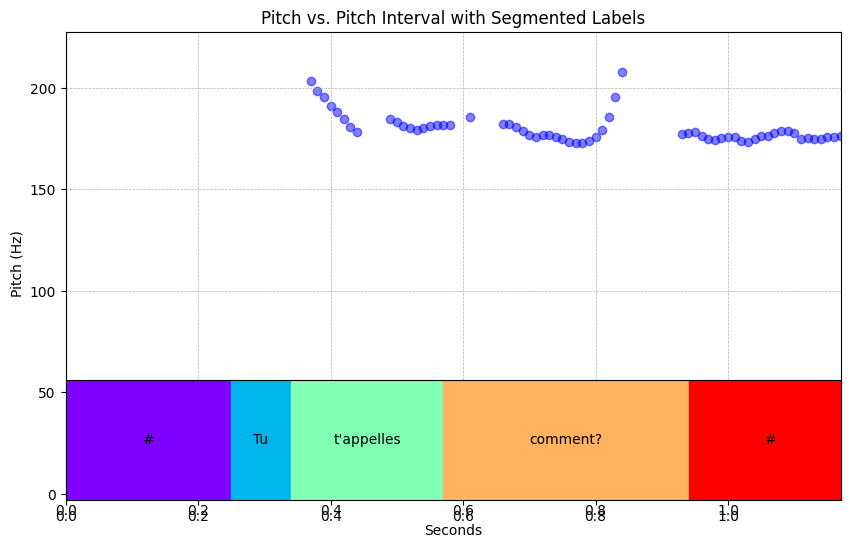

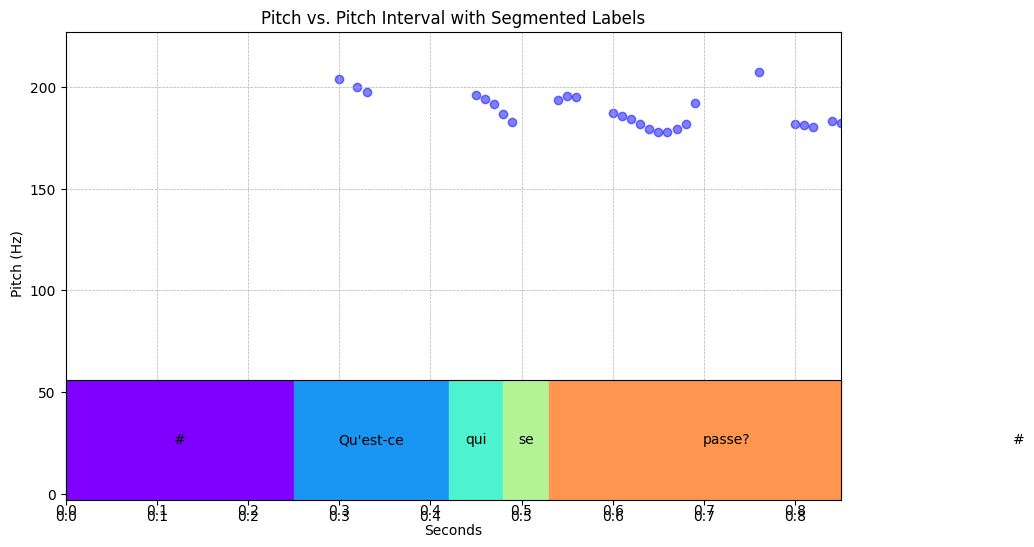

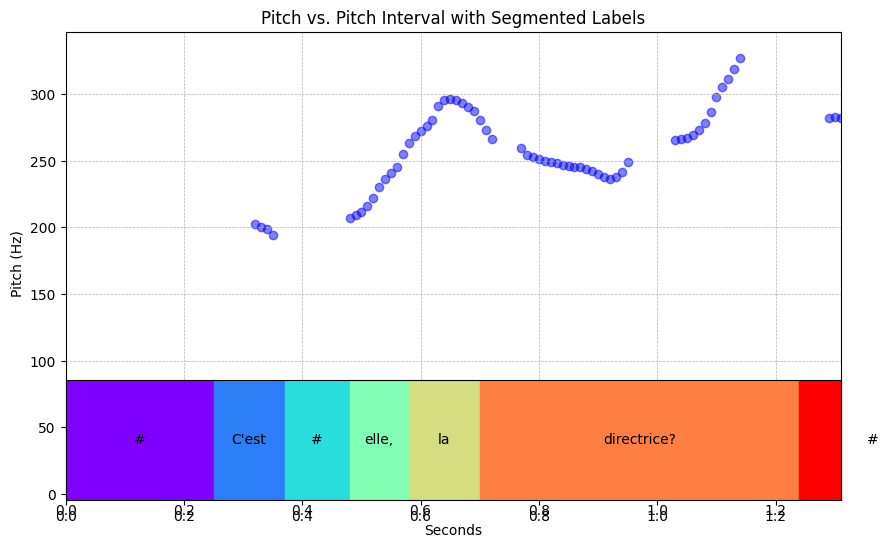

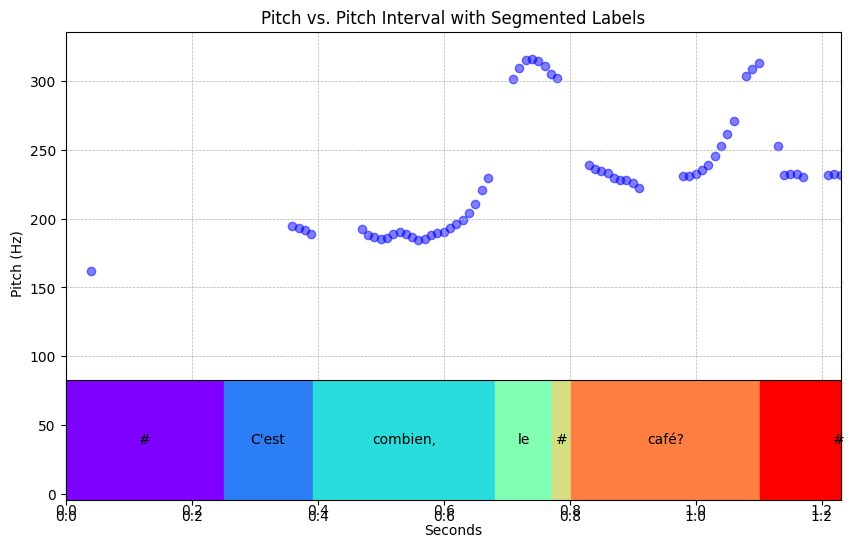

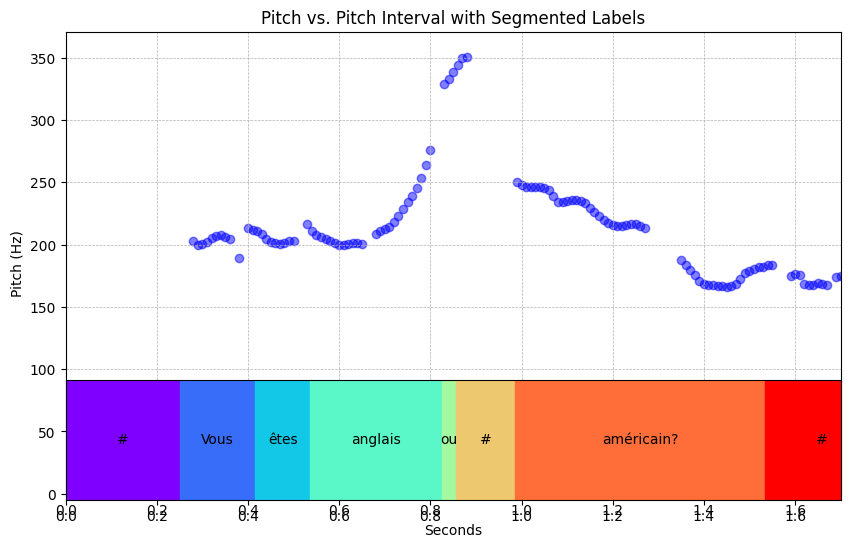

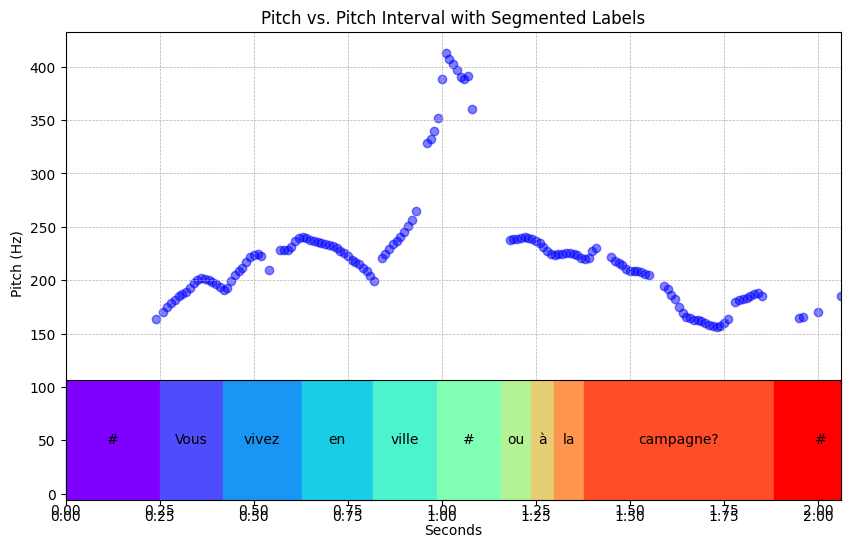

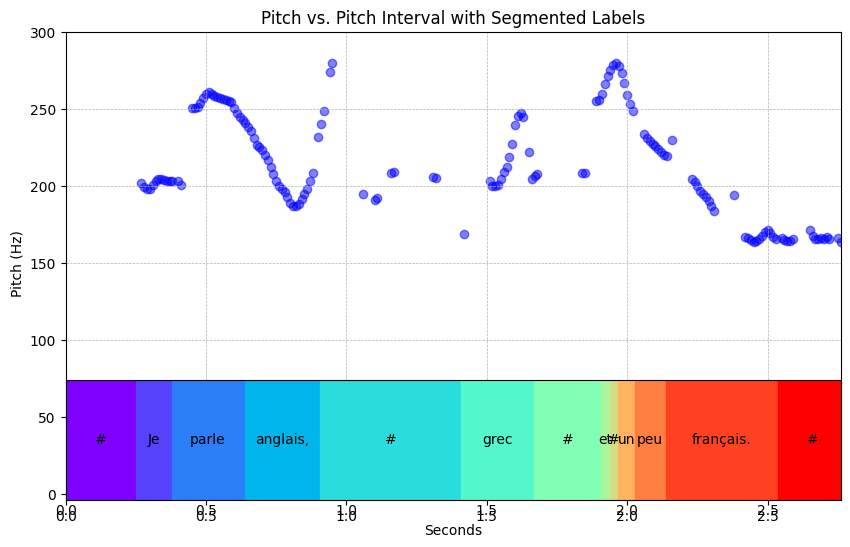

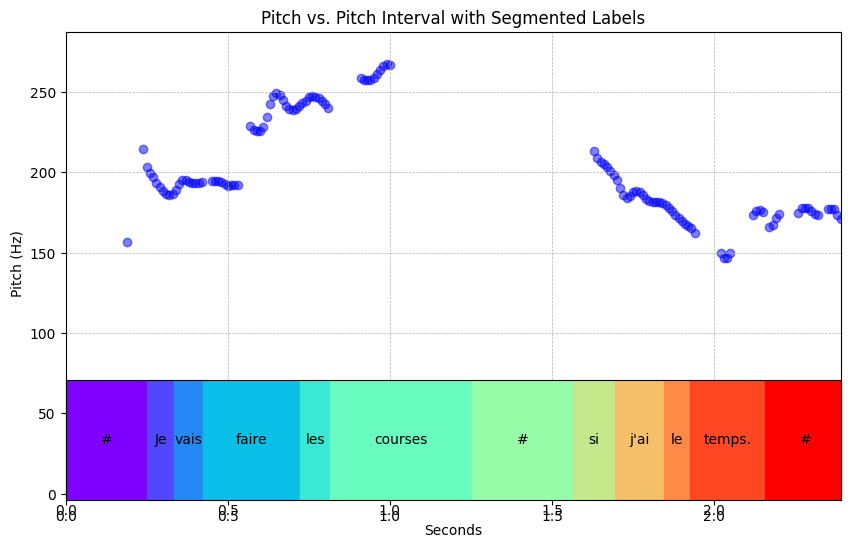

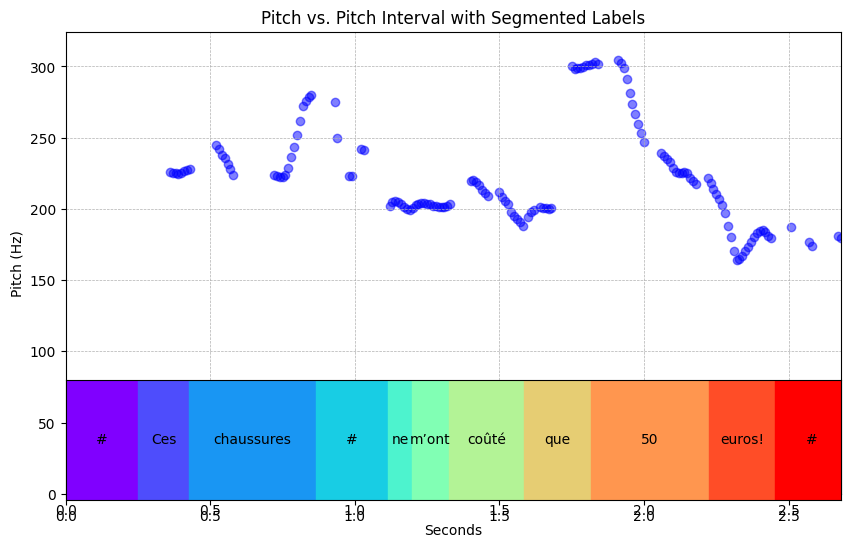

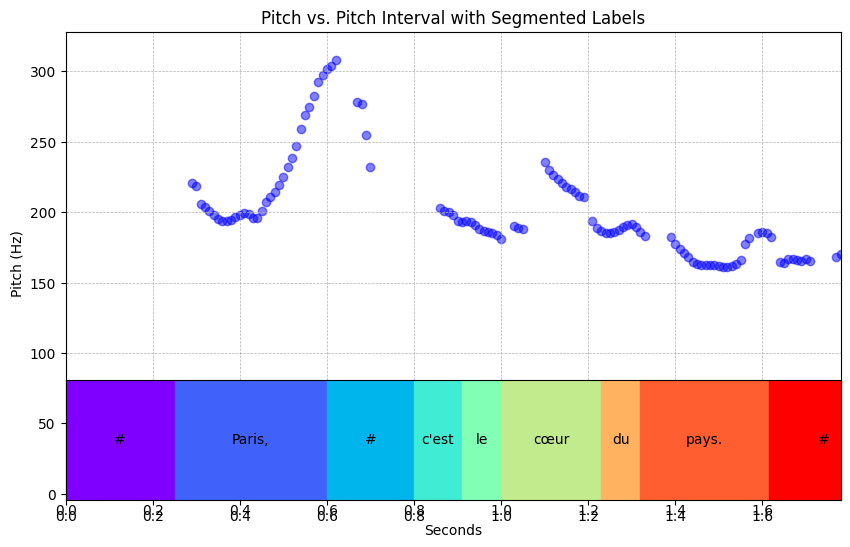

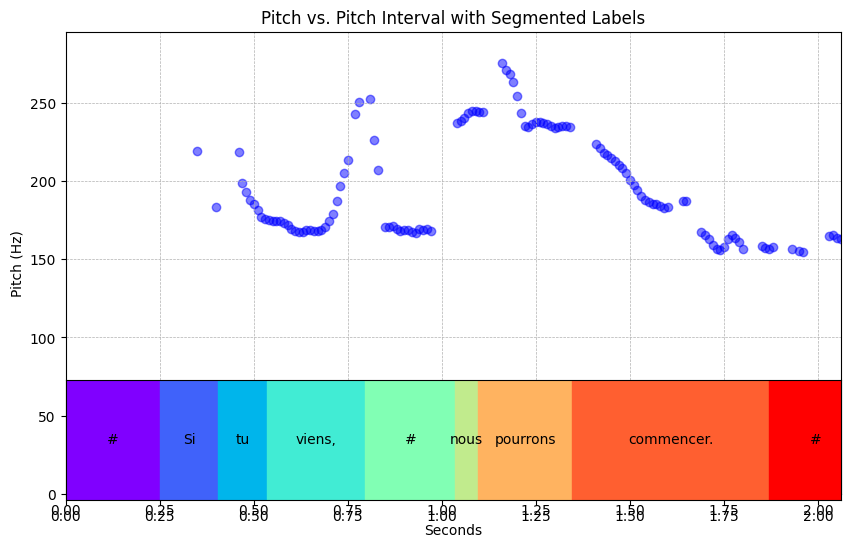

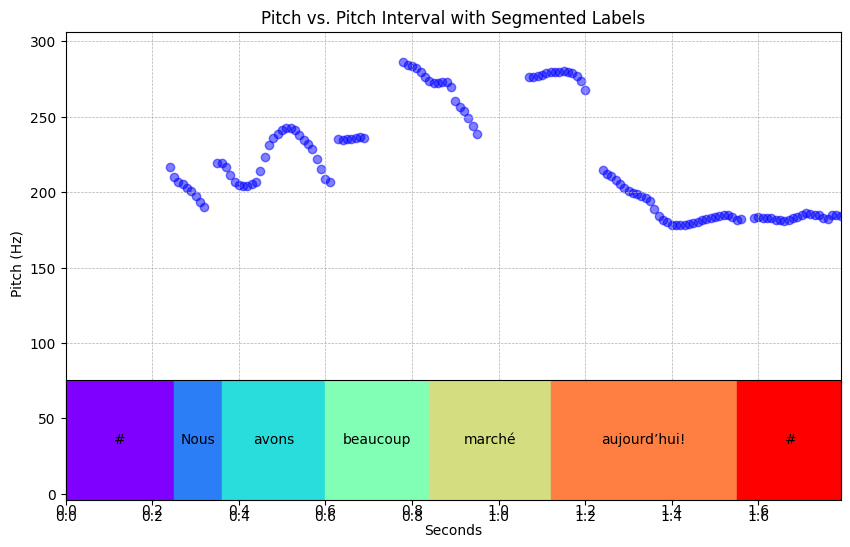

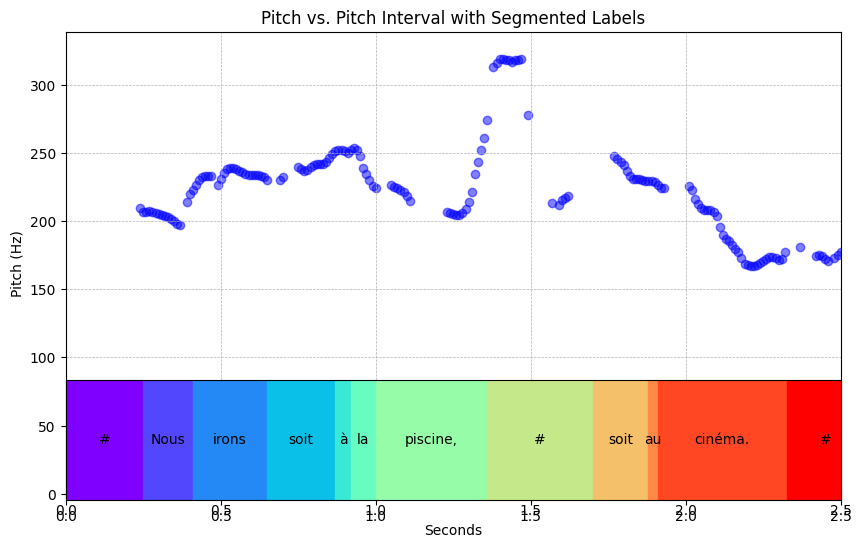

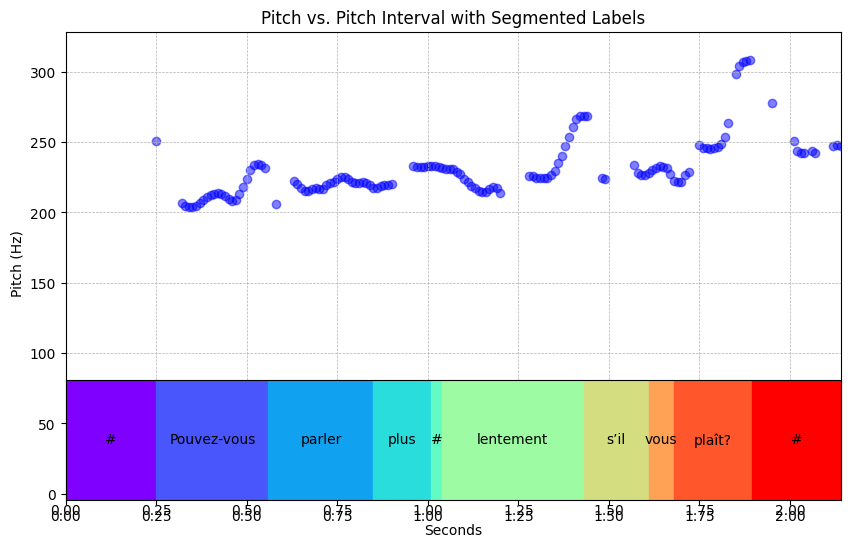

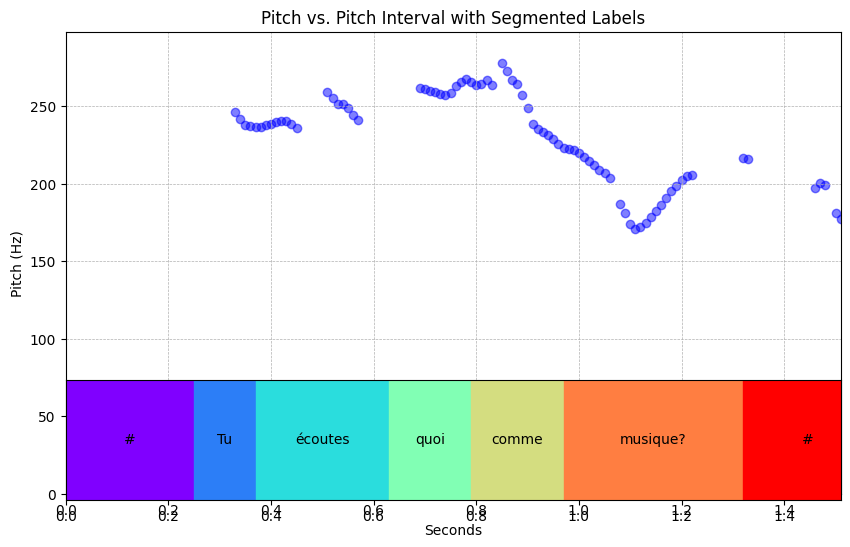

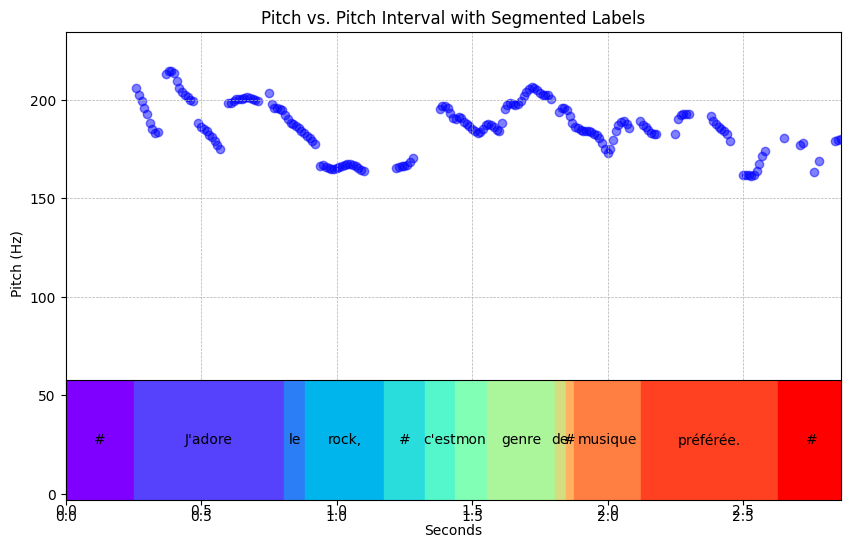

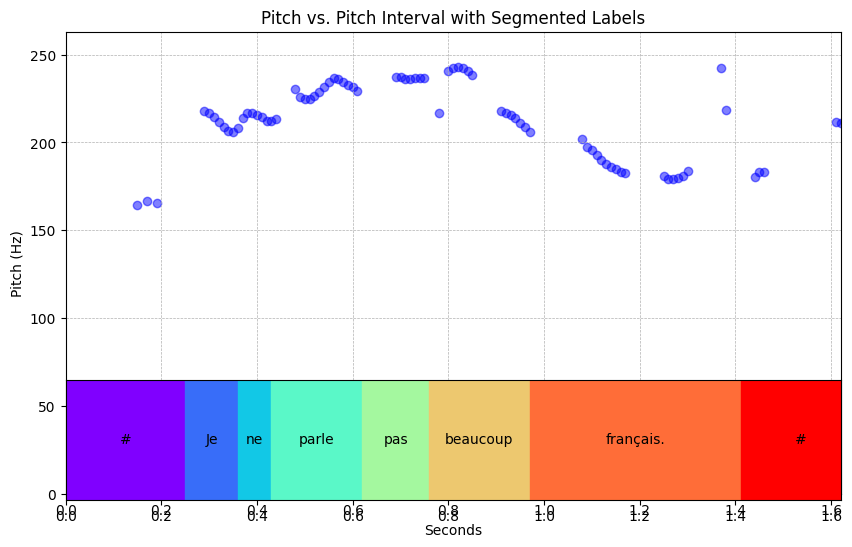

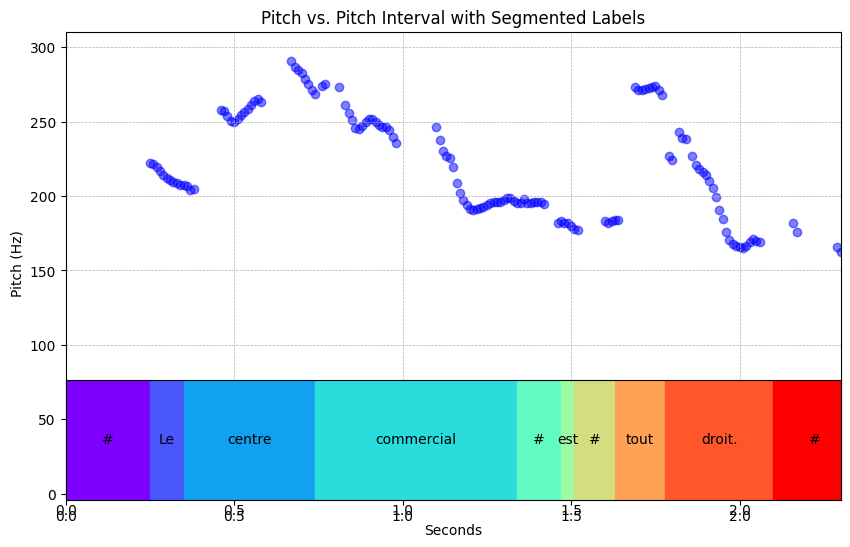

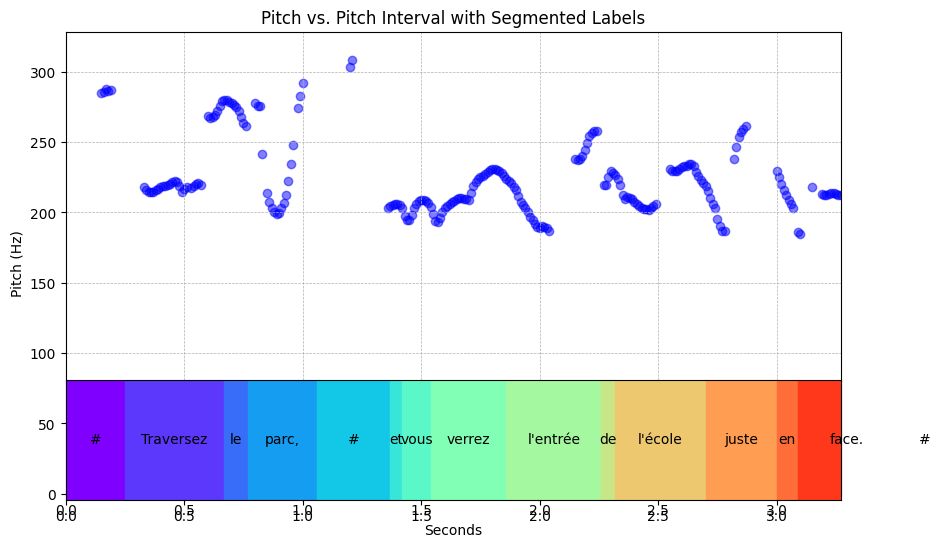

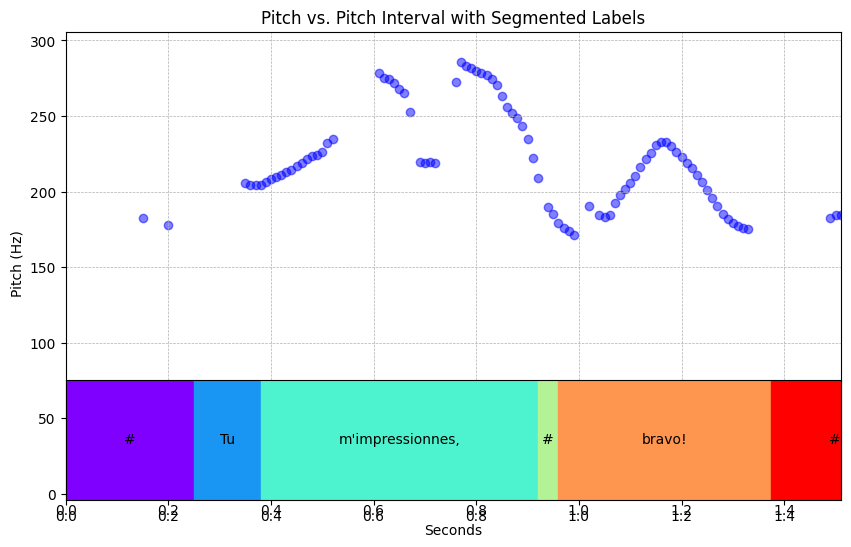

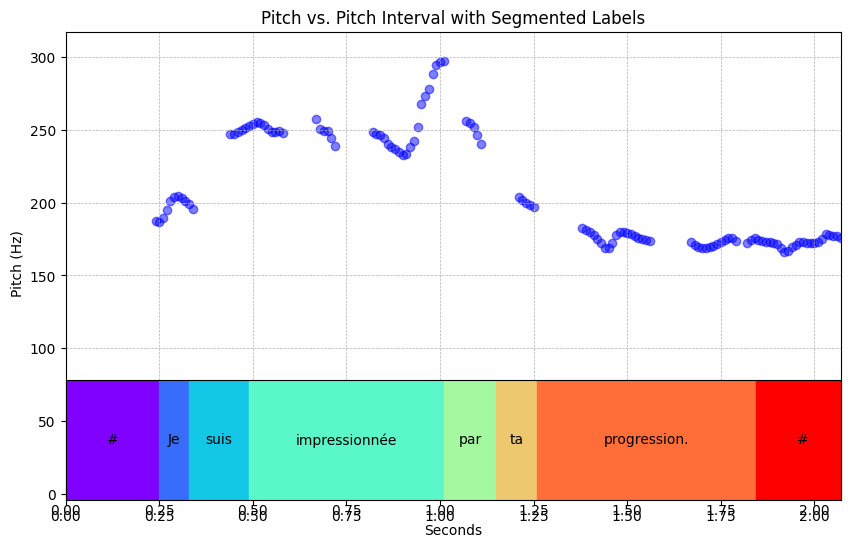

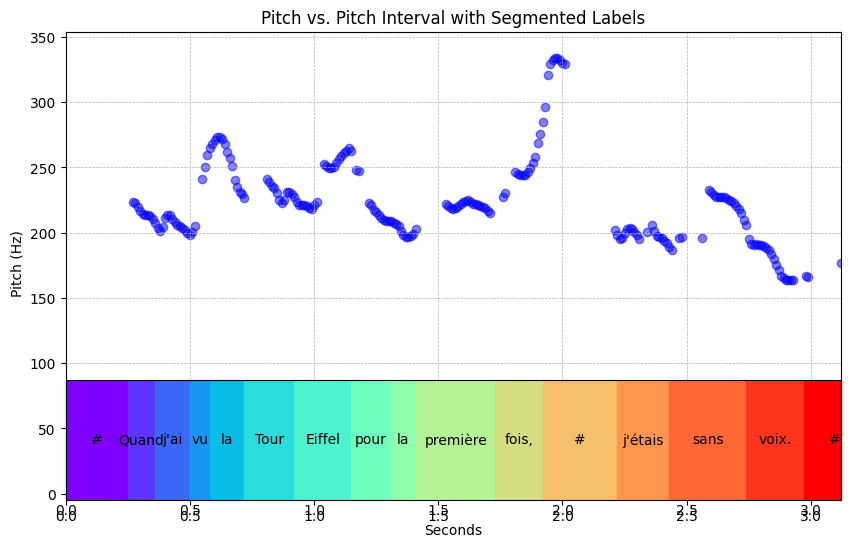

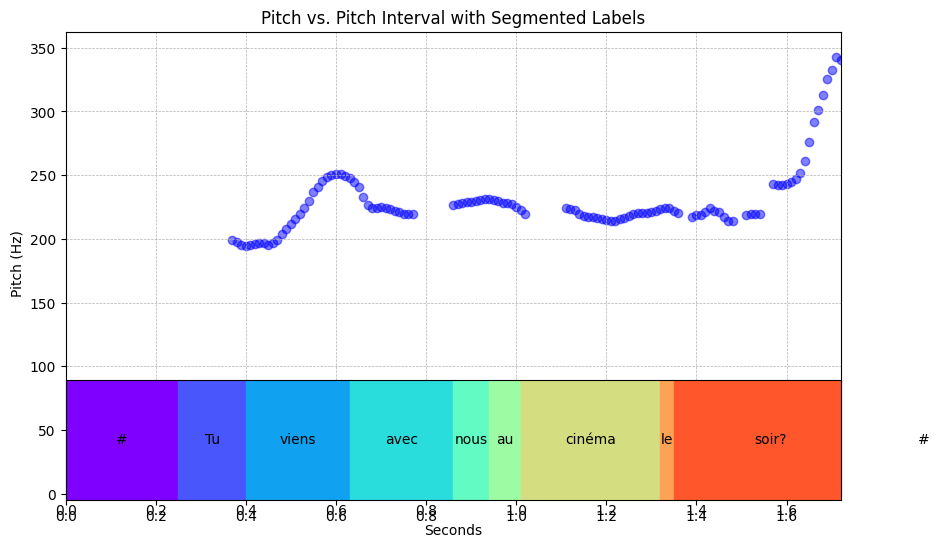

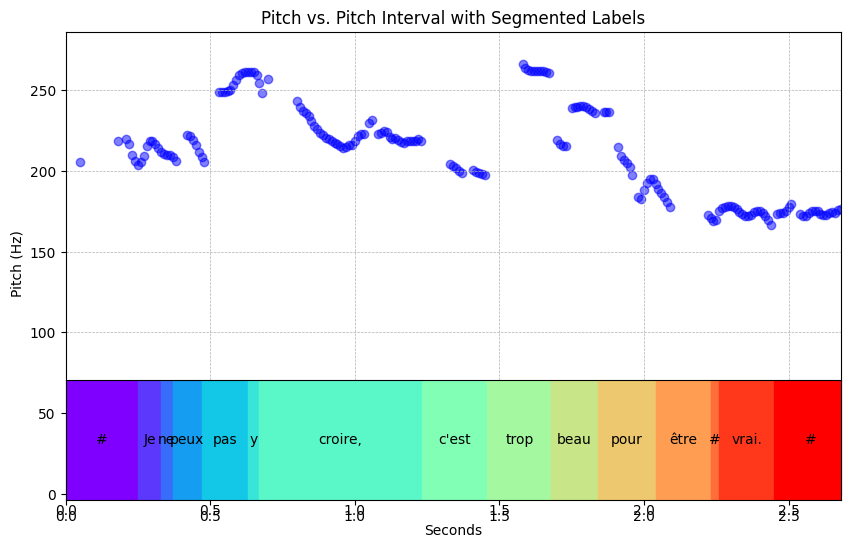

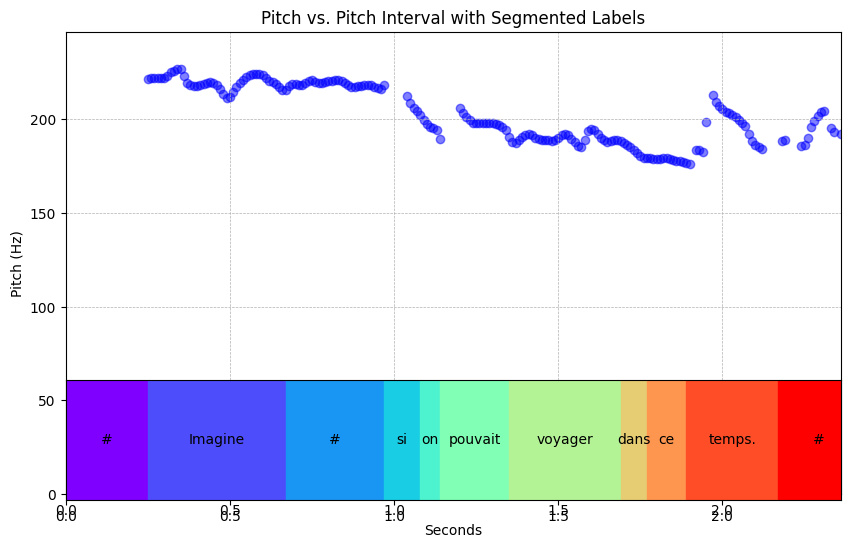

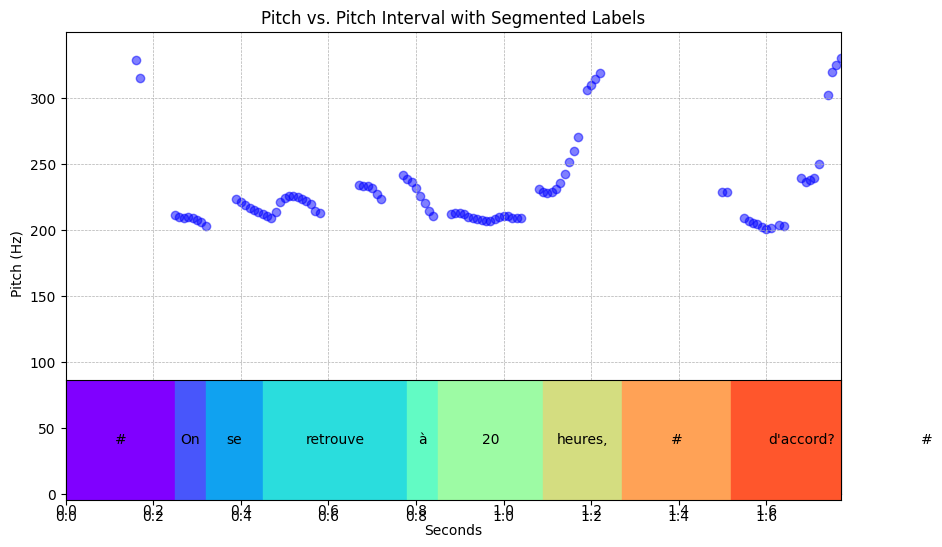

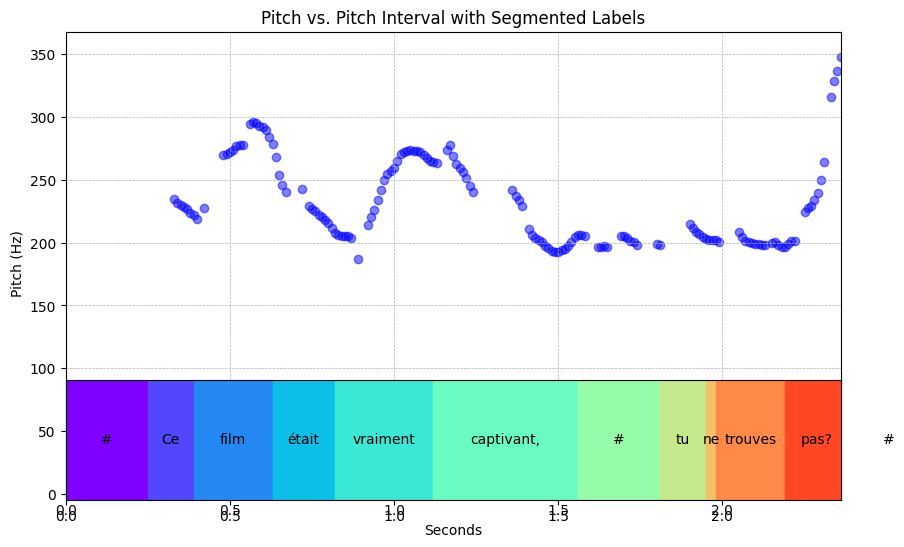

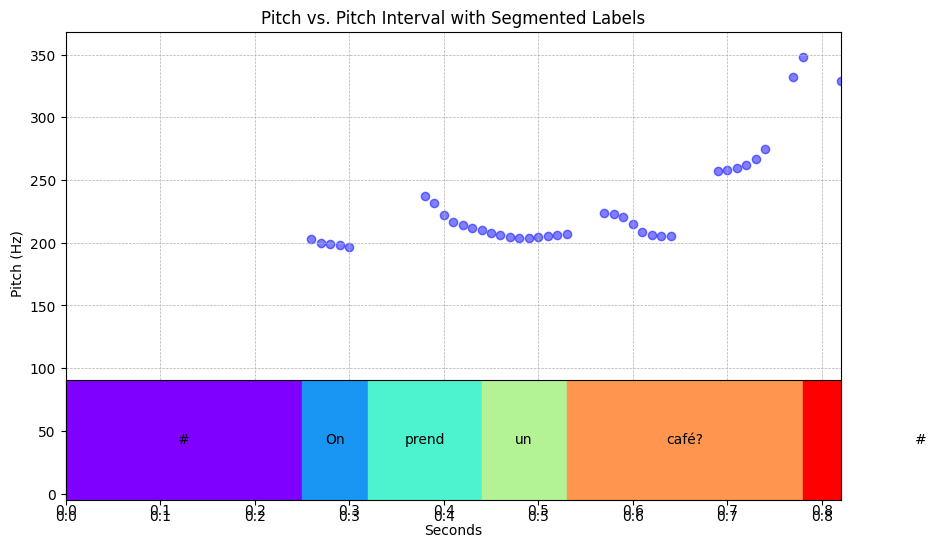

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step
6/6 ━━━━━━━━━━━━━━━

ValueError: max() arg is an empty sequence

In [8]:
for tg in glob.glob("data_segmented/*.textgrid"):
    tg_file = tg
    wav_file = tg.split('.')[0] + '.wav'
    extract_segments(wav_file, tg_file, pause_threshold=1000, buffer_time=250)
